In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the DuckDB database
con = duckdb.connect("../data/warehouse.duckdb")

# List tables (optional)
con.execute("SHOW ALL TABLES").df()


,database,schema,name,column_names,column_types,temporary
0,warehouse,prod,sales,"[chargedate, meterid, chargedate_str, loc, res...","[DATE, BIGINT, VARCHAR, VARCHAR, VARCHAR, VARC...",False


In [2]:
# Load data from prod.sales table
df = con.execute("SELECT * FROM prod.sales").df()

# Quick preview
df.head()


,chargedate,meterid,chargedate_str,loc,res,month,month_str,kwh,year,ghc,paymoney
0,2019-02-15,1,15-Feb-2019,Techiman [13],N-Resid [0],Feb-19,01-Feb-2019,14.2,2019,23.1705,140.0
1,2019-03-11,1,11-Mar-2019,Techiman [13],N-Resid [0],Mar-19,01-Mar-2019,57.4,2019,38.8886,40.0
2,2019-04-20,1,20-Apr-2019,Techiman [13],N-Resid [0],Apr-19,01-Apr-2019,57.4,2019,38.8886,20.0
3,2019-05-28,1,28-May-2019,Techiman [13],N-Resid [0],May-19,01-May-2019,57.4,2019,38.8886,20.0
4,2019-06-25,1,25-Jun-2019,Techiman [13],N-Resid [0],Jun-19,01-Jun-2019,57.4,2019,38.8886,20.0


We now inspect the structure, data types, and missing values to understand dataset quality and readiness for modeling.

In [3]:
df.info()
df.isna().sum()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2867046 entries, 0 to 2867045
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   chargedate      datetime64[us]
 1   meterid         int64         
 2   chargedate_str  object        
 3   loc             object        
 4   res             object        
 5   month           object        
 6   month_str       object        
 7   kwh             float64       
 8   year            int64         
 9   ghc             float64       
 10  paymoney        float64       
dtypes: datetime64[us](1), float64(3), int64(2), object(5)
memory usage: 240.6+ MB


,chargedate,meterid,chargedate_str,loc,res,month,month_str,kwh,year,ghc,paymoney
count,2867046,2.867046e+06,2867046,2867046,2867046,2867046,2867046,2.806103e+06,2.867046e+06,2.867046e+06,2.827728e+06
unique,NaN,NaN,3627,15,2,122,122,NaN,NaN,NaN,NaN
top,NaN,NaN,01-Sep-2020,Techiman [13],Resid [1],May-20,01-May-2020,NaN,NaN,NaN,NaN
freq,NaN,NaN,7000,1492880,2293855,57206,57206,NaN,NaN,NaN,NaN
mean,2018-02-17 20:07:38.873975,3.007559e+04,NaN,NaN,NaN,NaN,NaN,1.259905e+02,2.017648e+03,8.550323e+01,4.684029e+01
min,2012-07-17 00:00:00,1.000000e+00,NaN,NaN,NaN,NaN,NaN,1.300000e+00,2.012000e+03,3.530000e-02,0.000000e+00
25%,2016-10-17 00:00:00,9.909000e+03,NaN,NaN,NaN,NaN,NaN,5.000000e+01,2.016000e+03,1.669750e+01,1.500000e+01
50%,2018-07-23 00:00:00,3.085200e+04,NaN,NaN,NaN,NaN,NaN,8.700000e+01,2.018000e+03,3.882090e+01,3.000000e+01
75%,2019-09-25 00:00:00,4.746300e+04,NaN,NaN,NaN,NaN,NaN,1.504000e+02,2.019000e+03,7.387460e+01,5.000000e+01
max,2022-08-04 00:00:00,6.906500e+04,NaN,NaN,NaN,NaN,NaN,3.878000e+03,2.022000e+03,2.209250e+05,3.000000e+03


We clean the dataset by fixing column types, handling duplicates, and removing invalid records such as zero or negative kwh values.

In [4]:
df = df.drop_duplicates()

# Remove rows with missing or invalid numeric values
df = df[df['kwh'] > 0]
df = df[df['ghc'] >= 0]
df = df[df['paymoney'] >= 0]

# Drop rows with missing key fields
df = df.dropna(subset=['chargedate', 'loc', 'res'])

# Confirm cleaning
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2780016 entries, 0 to 2867045
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   chargedate      datetime64[us]
 1   meterid         int64         
 2   chargedate_str  object        
 3   loc             object        
 4   res             object        
 5   month           object        
 6   month_str       object        
 7   kwh             float64       
 8   year            int64         
 9   ghc             float64       
 10  paymoney        float64       
dtypes: datetime64[us](1), float64(3), int64(2), object(5)
memory usage: 254.5+ MB


In [5]:
df.head()

,chargedate,meterid,chargedate_str,loc,res,month,month_str,kwh,year,ghc,paymoney
0,2019-02-15,1,15-Feb-2019,Techiman [13],N-Resid [0],Feb-19,01-Feb-2019,14.2,2019,23.1705,140.0
1,2019-03-11,1,11-Mar-2019,Techiman [13],N-Resid [0],Mar-19,01-Mar-2019,57.4,2019,38.8886,40.0
2,2019-04-20,1,20-Apr-2019,Techiman [13],N-Resid [0],Apr-19,01-Apr-2019,57.4,2019,38.8886,20.0
3,2019-05-28,1,28-May-2019,Techiman [13],N-Resid [0],May-19,01-May-2019,57.4,2019,38.8886,20.0
4,2019-06-25,1,25-Jun-2019,Techiman [13],N-Resid [0],Jun-19,01-Jun-2019,57.4,2019,38.8886,20.0


Drop all useless columns

In [6]:
# Drop redundant date columns
df = df.drop(columns=['chargedate_str', 'month_str', 'month'], errors='ignore')

# Verify remaining columns
df.columns


Index(['chargedate', 'meterid', 'loc', 'res', 'kwh', 'year', 'ghc',
       'paymoney'],
      dtype='object')

Convert 'chargedate' to datetime

In [7]:
df['chargedate'] = pd.to_datetime(df['chargedate'], errors='coerce')

In [8]:
df.head()

,chargedate,meterid,loc,res,kwh,year,ghc,paymoney
0,2019-02-15,1,Techiman [13],N-Resid [0],14.2,2019,23.1705,140.0
1,2019-03-11,1,Techiman [13],N-Resid [0],57.4,2019,38.8886,40.0
2,2019-04-20,1,Techiman [13],N-Resid [0],57.4,2019,38.8886,20.0
3,2019-05-28,1,Techiman [13],N-Resid [0],57.4,2019,38.8886,20.0
4,2019-06-25,1,Techiman [13],N-Resid [0],57.4,2019,38.8886,20.0


## Exploratory Visuals (Numeric Distributions).

We plot histograms for key numeric variables to understand their range and detect possible outliers or skewed data that could affect modeling.

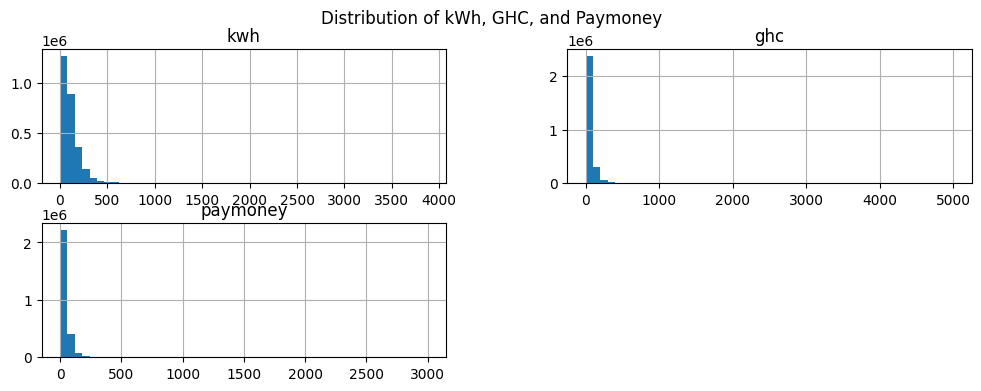

In [9]:
num_cols = ['kwh', 'ghc', 'paymoney']

df[num_cols].hist(bins=50, figsize=(12,4))
plt.suptitle('Distribution of kWh, GHC, and Paymoney')
plt.show()


We compute and visualize correlations between numeric variables to see which ones move together and could be useful predictors for modeling.

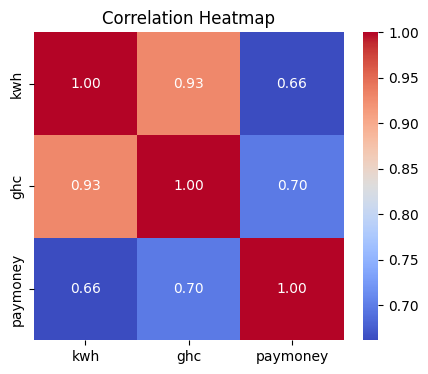

In [10]:
corr = df[['kwh', 'ghc', 'paymoney']].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


## Time Trend Analysis

To detect seasonality and anomalies, we visualize total monthly energy consumption across time.

C:\Users\Asus\AppData\Local\Temp\ipykernel_18444\2213021531.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key='chargedate', freq='M'))['kwh']


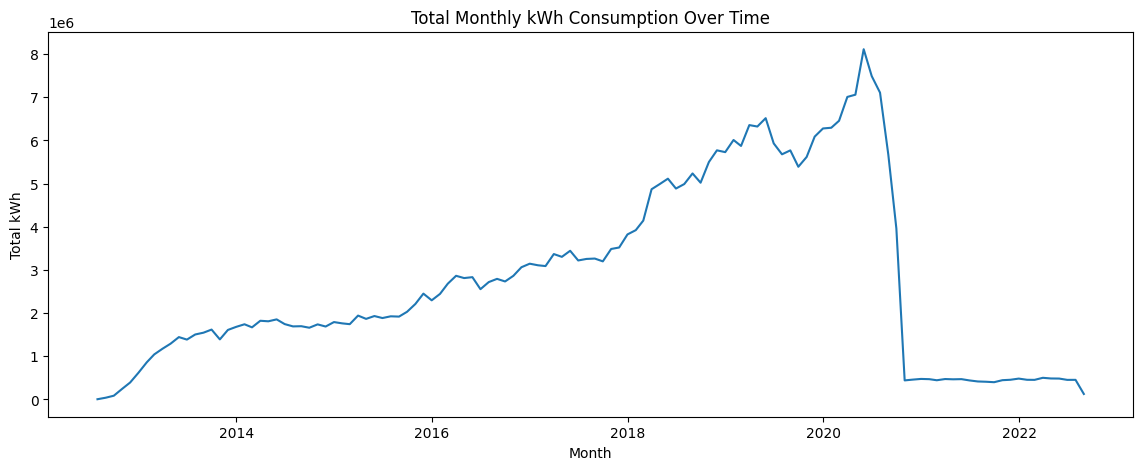

In [11]:
monthly_kwh = (
    df.groupby(pd.Grouper(key='chargedate', freq='M'))['kwh']
      .sum()
      .reset_index()
)

plt.figure(figsize=(14,5))
plt.plot(monthly_kwh['chargedate'], monthly_kwh['kwh'])
plt.title('Total Monthly kWh Consumption Over Time')
plt.xlabel('Month')
plt.ylabel('Total kWh')
plt.show()


## Detect Data Collection Drop

We identify when data collection dropped by tracking the number of unique meters reporting each month. A sudden drop indicates when the system started missing data.

C:\Users\Asus\AppData\Local\Temp\ipykernel_18444\3823037000.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key='chargedate', freq='M'))['meterid']


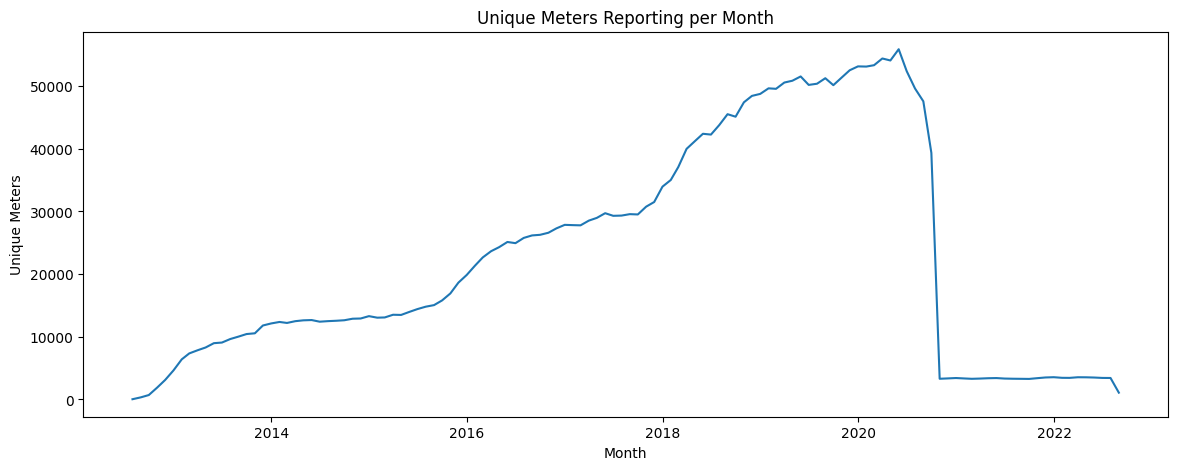

chargedate       2020-10-31 00:00:00
unique_meters                   3303
Name: 99, dtype: object

In [12]:
meter_counts = (
    df.groupby(pd.Grouper(key='chargedate', freq='M'))['meterid']
      .nunique()
      .reset_index(name='unique_meters')
)

plt.figure(figsize=(14,5))
plt.plot(meter_counts['chargedate'], meter_counts['unique_meters'])
plt.title('Unique Meters Reporting per Month')
plt.xlabel('Month')
plt.ylabel('Unique Meters')
plt.show()

# Optional: find the month with maximum drop
drop_month = meter_counts.loc[meter_counts['unique_meters'].diff().idxmin()]
drop_month


In [17]:
# Calculate month-to-month change in meter counts
meter_counts['diff'] = meter_counts['unique_meters'].diff()

meter_counts[meter_counts['chargedate'] >= '2019-01-01']


,chargedate,unique_meters,diff
78,2019-01-31,49642,886.0
79,2019-02-28,49566,-76.0
80,2019-03-31,50567,1001.0
81,2019-04-30,50856,289.0
82,2019-05-31,51540,684.0
83,2019-06-30,50191,-1349.0
84,2019-07-31,50378,187.0
85,2019-08-31,51257,879.0
86,2019-09-30,50148,-1109.0
87,2019-10-31,51360,1212.0


### 🧩 Data Quality Summary — Unique Meter Counts

- **Stable period:** From **January 2019 to May 2020**, the dataset maintained consistent coverage  
  averaging **~50,000–56,000 unique meters per month**.

- **Decline phase:** A noticeable reduction begins after **June 2020**:
  - **Jun 2020:** 52,375 meters  
  - **Jul 2020:** 49,615 meters  
  - **Aug 2020:** 47,572 meters  
  - **Sep 2020:** 39,339 meters  
  - **Oct 2020:** 3,303 meters  

- **Post-drop:** After **October 2020**, meter counts remain around **3,000–3,400**,  
  indicating a **>90% collapse in data collection**.

#### ✅ Conclusion
Only data **before July 2020** should be used for meaningful analysis or model training,  
as later records are incomplete and not representative of the true population.


## Location and Residence Insights

We now analyze average energy consumption (kwh) by location and residence type to detect regional usage patterns and customer behavior differences.

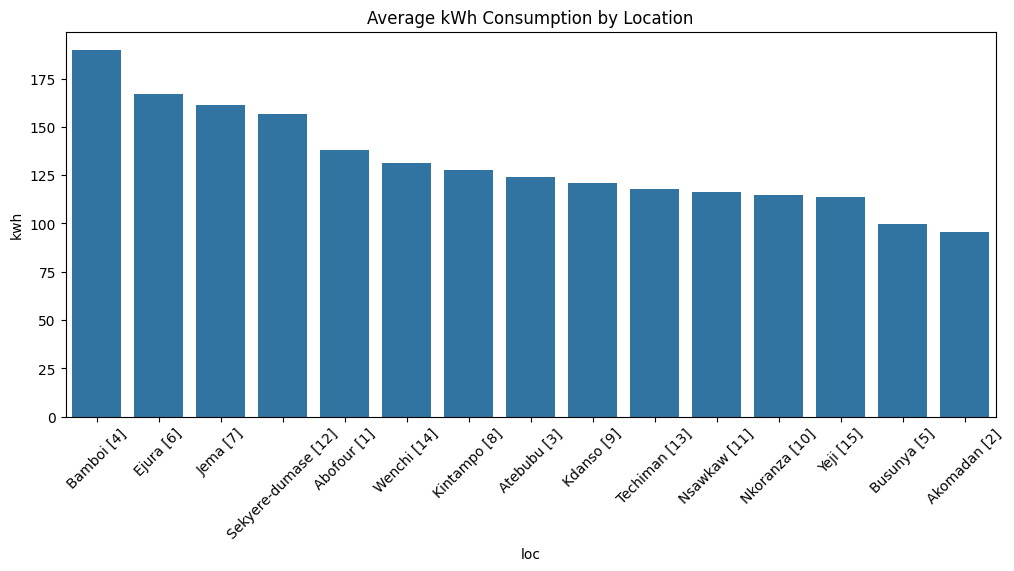

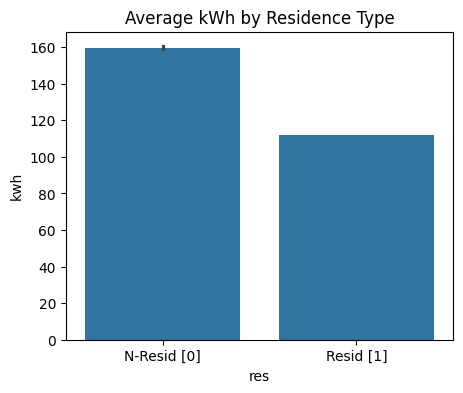

In [19]:
# Average kWh by location
loc_kwh = (
    df.groupby('loc')['kwh']
      .mean()
      .sort_values(ascending=False)
      .reset_index()
)

plt.figure(figsize=(12,5))
sns.barplot(data=loc_kwh, x='loc', y='kwh')
plt.title('Average kWh Consumption by Location')
plt.xticks(rotation=45)
plt.show()

# Average kWh by residence type
plt.figure(figsize=(5,4))
sns.barplot(data=df, x='res', y='kwh')
plt.title('Average kWh by Residence Type')
plt.show()


### ⚡ Regional and Customer Type Consumption Insights

#### 🌍 By Location
- **Bamboi**, **Ejura**, and **Jema** record the **highest average electricity usage**, each exceeding **160 kWh/month**.  
- **Akomadan** and **Busunya** have the **lowest averages**, both below **100 kWh/month**.  
- These differences suggest that high-consumption regions may have greater industrial, commercial, or population density.  
- Such regional variation is valuable for:
  - Building **location-based prediction models**
  - Prioritizing **data validation** in high-variance areas

#### 🏠 By Residence Type
- **Non-residential (N-Resid [0])** meters consume about **45% more electricity** than **residential (Resid [1])** meters.  
- Non-residential usage likely includes **shops, offices, and institutions** with longer operating hours.  
- Residential meters show lower but more stable consumption, which can help **stabilize forecasting models** when grouped separately.


## Seasonal Consumption Patterns

We calculate average monthly consumption across all years to observe seasonal trends and identify peak-demand months.

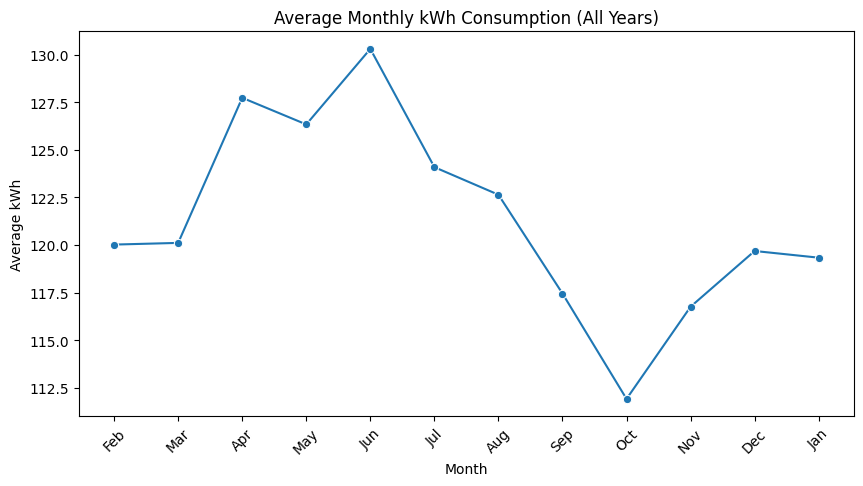

In [20]:
# Extract month name for grouping
df['month_num'] = df['chargedate'].dt.month
df['month_name'] = df['chargedate'].dt.strftime('%b')

# Average kWh by month
monthly_pattern = (
    df.groupby('month_num')['kwh']
      .mean()
      .reset_index()
      .sort_values('month_num')
)

plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_pattern, x='month_num', y='kwh', marker='o')
plt.xticks(monthly_pattern['month_num'], df['month_name'].unique(), rotation=45)
plt.title('Average Monthly kWh Consumption (All Years)')
plt.xlabel('Month')
plt.ylabel('Average kWh')
plt.show()


### 📆 Seasonal Consumption Patterns

- Monthly averages fluctuate only slightly (≈ ±10 kWh).  
- Peak usage occurs around **June**, while the lowest levels appear in **October**.  
- The narrow range indicates **limited seasonality** — energy demand is relatively stable throughout the year.  
- Models do **not need strong seasonal adjustment**, though including `month` as a feature may still capture minor periodic effects.


## Yearly Consumption Trend

We aggregate average annual consumption to observe long-term usage growth and verify the effect of the 2020 data collection issue.

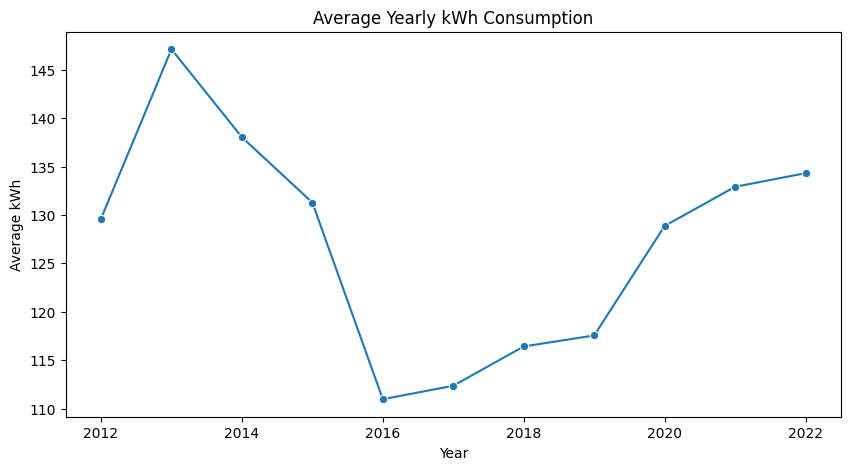

In [21]:
yearly_trend = (
    df.groupby('year')['kwh']
      .mean()
      .reset_index()
      .sort_values('year')
)

plt.figure(figsize=(10,5))
sns.lineplot(data=yearly_trend, x='year', y='kwh', marker='o')
plt.title('Average Yearly kWh Consumption')
plt.xlabel('Year')
plt.ylabel('Average kWh')
plt.show()


### 📈 Yearly Consumption Trend

- Average consumption **peaked in 2013 (~146 kWh)**, then **declined steadily** until 2016 (~111 kWh).  
- From **2017–2019**, consumption gradually recovered, showing a **slow upward trend**.  
- **2020 and later years appear unstable** because of the known **data collection drop**, so their values are not reliable.  
- Overall, the trend indicates a period of early growth, mid-term decline, and partial recovery before the 2020 disruption.


## Weekday vs Weekend Consumption

We examine daily energy consumption patterns to see whether weekdays differ from weekends, which reflects behavioral and business activity patterns.

Average kWh consumption by weekday:
     weekday         kwh
0     Monday  121.037010
1    Tuesday  119.582244
2  Wednesday  121.275393
3   Thursday  120.651050
4     Friday  120.497028
5   Saturday  124.790992
6     Sunday  125.135104


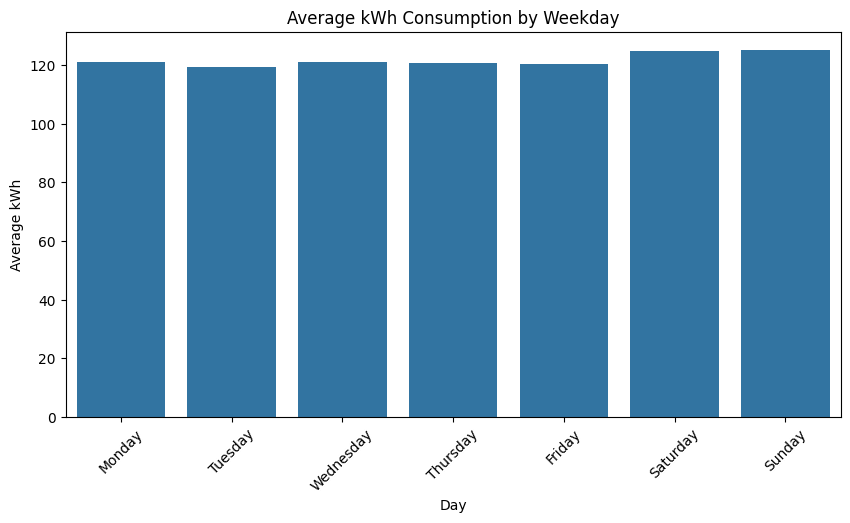

In [24]:
# Extract weekday and weekend flag
df['weekday'] = df['chargedate'].dt.day_name()
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday'])

# Compute average consumption per weekday
weekday_pattern = (
    df.groupby('weekday')['kwh']
      .mean()
      .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
      .reset_index()
)

# Print values
print("Average kWh consumption by weekday:")
print(weekday_pattern)

# Plot
plt.figure(figsize=(10,5))
sns.barplot(data=weekday_pattern, x='weekday', y='kwh')
plt.title('Average kWh Consumption by Weekday')
plt.xlabel('Day')
plt.ylabel('Average kWh')
plt.xticks(rotation=45)
plt.show()

### 📅 Weekday vs Weekend Consumption

| Day | Avg kWh |
|-----|----------|
| Monday | 121.0 |
| Tuesday | 119.6 |
| Wednesday | 121.3 |
| Thursday | 120.7 |
| Friday | 120.5 |
| Saturday | 124.8 |
| Sunday | 125.1 |

- **Weekend usage (Sat–Sun)** is slightly higher — about **3–4% above weekdays**.  
- The difference is small but consistent, suggesting **increased home activity** or reduced business operations on weekends.  
- Overall, weekday patterns remain stable, so a simple binary feature `is_weekend` is enough for modeling rather than daily dummy variables.


## Weekday vs Weekend by Residence Type

We now compare weekday and weekend energy usage for residential and non-residential customers to detect behavioral differences between the two groups.

Average kWh consumption by residence type and day type:
               res day_type         kwh
0      Residential  Weekday  157.789536
1      Residential  Weekend  169.135096
2  Non-Residential  Weekday  110.909071
3  Non-Residential  Weekend  116.121891


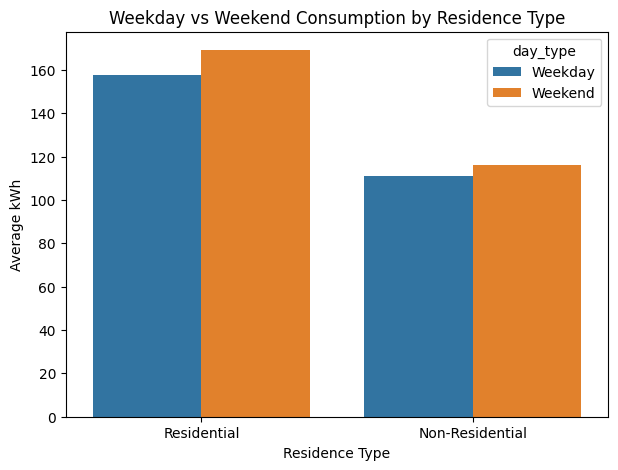

In [27]:
# Group by residence type and weekend flag
res_wk_pattern = (
    df.groupby(['res', 'is_weekend'])['kwh']
      .mean()
      .reset_index()
)

# Map readable labels
res_wk_pattern['res'] = res_wk_pattern['res'].map({'Resid [1]': 'Non-Residential', 'N-Resid [0]': 'Residential'})
res_wk_pattern['day_type'] = res_wk_pattern['is_weekend'].map({True: 'Weekend', False: 'Weekday'})

print("Average kWh consumption by residence type and day type:")
print(res_wk_pattern[['res', 'day_type', 'kwh']])

# Plot comparison
plt.figure(figsize=(7,5))
sns.barplot(data=res_wk_pattern, x='res', y='kwh', hue='day_type')
plt.title('Weekday vs Weekend Consumption by Residence Type')
plt.xlabel('Residence Type')
plt.ylabel('Average kWh')
plt.show()


### 🕒 Weekday vs Weekend Consumption by Residence Type

| Residence Type | Weekday (kWh) | Weekend (kWh) |
|----------------|----------------|----------------|
| Residential | 157.8 | 169.1 |
| Non-Residential | 110.9 | 116.1 |

- **Residential customers** consume **~7% more electricity on weekends**, likely due to people spending more time at home.  
- **Non-residential users** also show a slight weekend increase, possibly from continuous operations or small-scale businesses.  
- Both groups follow the same trend, but residential usage remains **consistently higher overall**.  
- This indicates that weekday/weekend patterns are relevant features, especially when combined with the `res` variable for prediction modeling.


## Relationship Between Energy Use and Payments

We analyze how energy consumption (kwh) relates to monetary variables (ghc, paymoney).
A strong linear relationship would confirm data consistency and help identify which variable better represents actual payments.

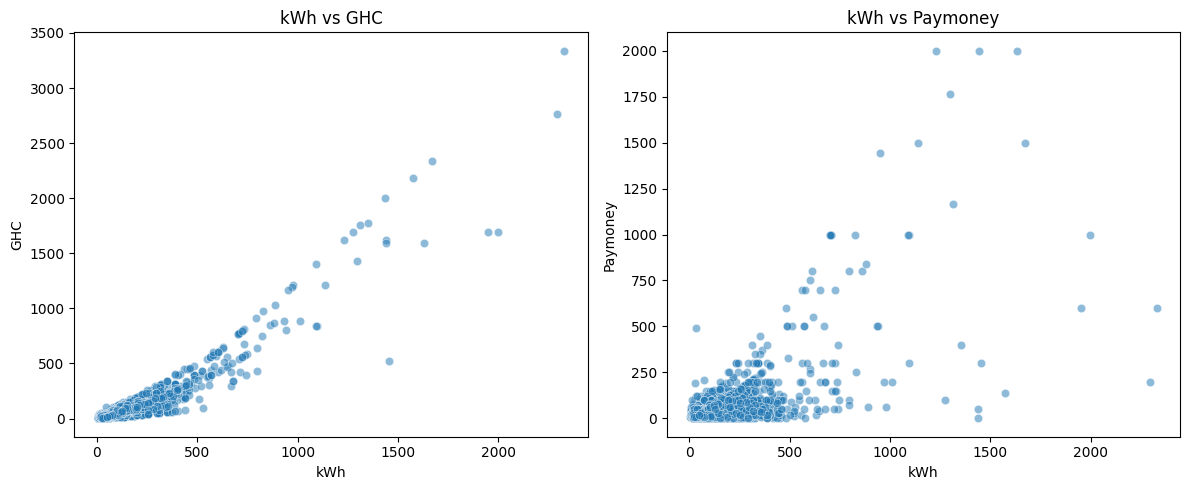

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# kWh vs GHC
sns.scatterplot(data=df.sample(5000, random_state=1), x='kwh', y='ghc', alpha=0.5, ax=ax[0])
ax[0].set_title('kWh vs GHC')
ax[0].set_xlabel('kWh')
ax[0].set_ylabel('GHC')

# kWh vs Paymoney
sns.scatterplot(data=df.sample(5000, random_state=1), x='kwh', y='paymoney', alpha=0.5, ax=ax[1])
ax[1].set_title('kWh vs Paymoney')
ax[1].set_xlabel('kWh')
ax[1].set_ylabel('Paymoney')

plt.tight_layout()
plt.show()


### 💰 Relationship Between Energy Use and Payments

- The scatterplots show a **nonlinear (exponential-like)** relationship between `kwh` and monetary values.  
- **`ghc`** rises more smoothly with `kwh`, indicating a consistent pricing formula.  
- **`paymoney`** is noisier — possibly due to partial payments, rounding, or delayed transactions.  
- For predictive modeling:
  - Use `ghc` as the **target** if modeling energy cost.
  - Use `kwh` as the **target** if modeling consumption, and include `ghc` as a strong predictor.


## MeterID Activity Analysis

We analyze how many readings each meter contributes to detect imbalance and understand meter activity levels across the dataset.

Unique meters: 68963
Average records per meter: 40.31170337717327
Median records per meter: 33.0

Meter with the most records:
meterid    39135
records      122
Name: 39075, dtype: int64


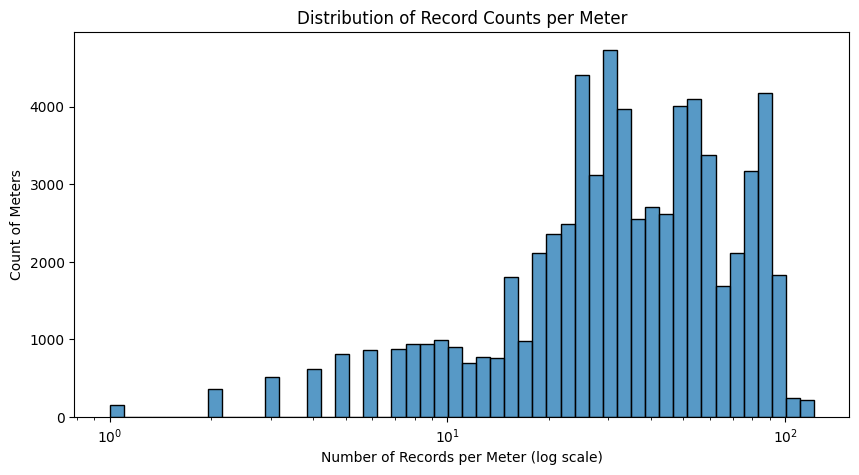

In [32]:
# Correct count of records per meter
meter_activity = (
    df.groupby('meterid')
      .size()
      .reset_index(name='records')
      .sort_values('records', ascending=False)
)

# Summary stats
print("Unique meters:", meter_activity.shape[0])
print("Average records per meter:", meter_activity['records'].mean())
print("Median records per meter:", meter_activity['records'].median())

# Meter with the most records
top_meter = meter_activity.iloc[0]
print("\nMeter with the most records:")
print(top_meter)

# Plot distribution (log scale)
plt.figure(figsize=(10,5))
sns.histplot(meter_activity['records'], bins=50, log_scale=True)
plt.title('Distribution of Record Counts per Meter')
plt.xlabel('Number of Records per Meter (log scale)')
plt.ylabel('Count of Meters')
plt.show()


### ⚙️ Meter Activity Distribution

- **Unique meters:** 68,963  
- **Average records per meter:** ~40  
- **Median records per meter:** 33  
- **Most active meter:** ID **39135** with **122 records**

#### Observations
- Most meters have **30–50 readings**, which fits a monthly or periodic billing cycle.  
- The distribution is **right-skewed**, meaning a small fraction of meters have unusually long histories.  
- This confirms data is balanced enough to analyze per-meter behavior, though not all meters span the full study period.  
- The most active meter (39135) could be inspected separately for data quality or usage pattern consistency.



## Meter Activity by Location

We check how meter activity (number of readings per meter) varies by city to identify which locations have the most consistent or longest reporting history.

Average number of records per meter by location:
                    loc    records
0           Wenchi [14]  49.337975
1         Techiman [13]  44.298875
2             Yeji [15]  38.217192
3            Kdanso [9]  37.560990
4          Akomadan [2]  36.062748
5          Nsawkaw [11]  35.941458
6           Atebubu [3]  33.421230
7          Kintampo [8]  31.324458
8             Ejura [6]  31.024982
9         Nkoranza [10]  30.793248
10  Sekyere-dumase [12]  26.916667
11          Abofour [1]  24.108553
12           Bamboi [4]  22.793144
13          Busunya [5]  22.783550
14             Jema [7]  20.172414


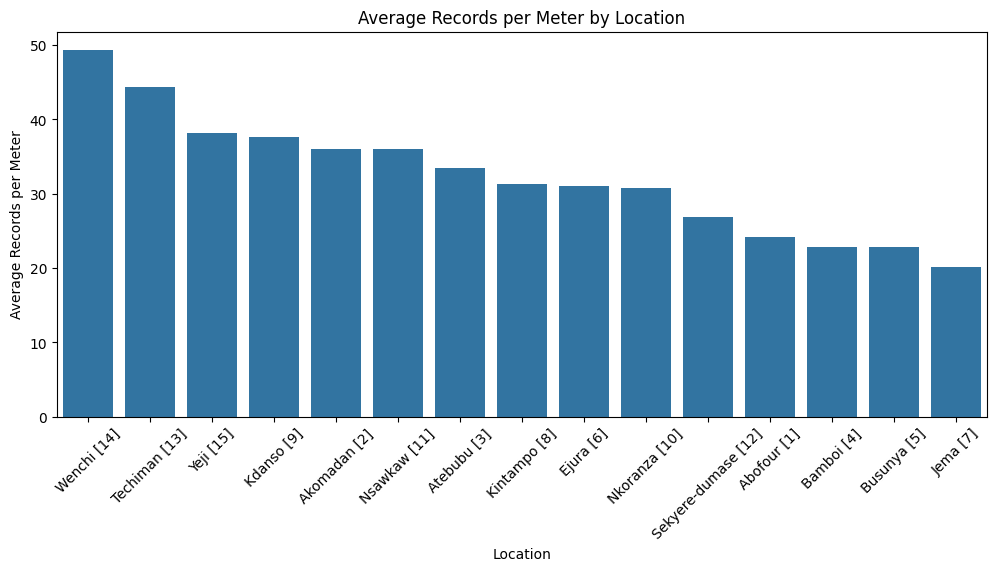

In [33]:
# Calculate average records per meter per location
meter_loc = (
    df.groupby(['loc', 'meterid'])
      .size()
      .reset_index(name='records')
)

loc_activity = (
    meter_loc.groupby('loc')['records']
             .mean()
             .sort_values(ascending=False)
             .reset_index()
)

print("Average number of records per meter by location:")
print(loc_activity)

# Plot
plt.figure(figsize=(12,5))
sns.barplot(data=loc_activity, x='loc', y='records')
plt.title('Average Records per Meter by Location')
plt.xlabel('Location')
plt.ylabel('Average Records per Meter')
plt.xticks(rotation=45)
plt.show()


### 🏙️ Meter Activity by Location

| Location | Avg Records per Meter |
|-----------|-----------------------|
| Wenchi [14] | 49.3 |
| Techiman [13] | 44.3 |
| Yeji [15] | 38.2 |
| Jema [7] | 20.2 |
| ... | ... |

#### Observations
- **Wenchi** and **Techiman** have the **most active meters**, averaging around **45–50 records per meter** — indicating better data continuity and possibly longer operational history.  
- **Jema**, **Busunya**, and **Bamboi** have the **least active meters**, suggesting late deployment or more missing data.  
- The variation across cities highlights where **data completeness differs**, which matters when training prediction models — locations with fewer readings may produce less reliable trends.  


## Average and Variability of kWh per Meter

We analyze how much electricity each meter typically consumes and how consistent that usage is.
This helps identify stable vs. erratic consumption patterns across meters.

Average kWh per meter (mean of means): 117.40565094042468
Average variability (mean of std): 46.80961398123386


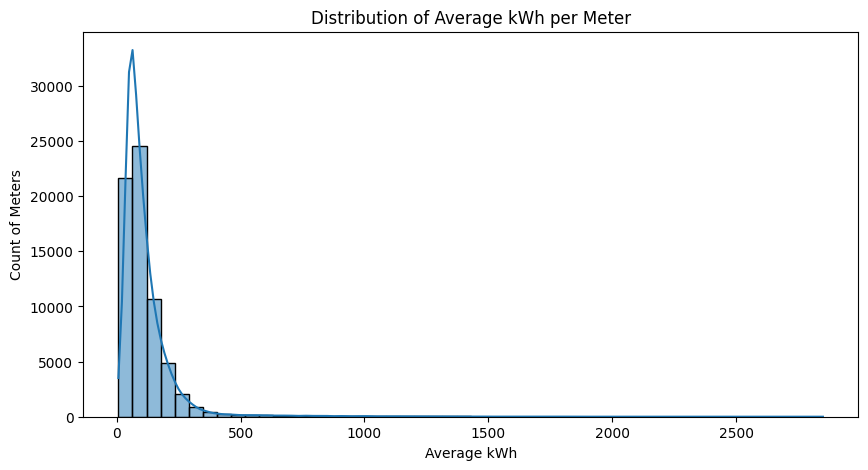

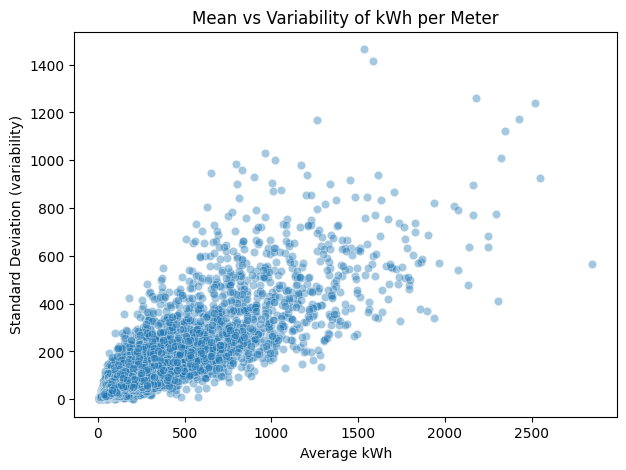

In [34]:
# Compute mean and std of kWh per meter
meter_usage = (
    df.groupby('meterid')['kwh']
      .agg(['mean', 'std', 'count'])
      .reset_index()
)

# Remove meters with very few records (unstable averages)
meter_usage = meter_usage[meter_usage['count'] > 5]

# Summary
print("Average kWh per meter (mean of means):", meter_usage['mean'].mean())
print("Average variability (mean of std):", meter_usage['std'].mean())

# Plot distribution of average kWh per meter
plt.figure(figsize=(10,5))
sns.histplot(meter_usage['mean'], bins=50, kde=True)
plt.title('Distribution of Average kWh per Meter')
plt.xlabel('Average kWh')
plt.ylabel('Count of Meters')
plt.show()

# Plot relationship between mean and std (stability)
plt.figure(figsize=(7,5))
sns.scatterplot(data=meter_usage, x='mean', y='std', alpha=0.4)
plt.title('Mean vs Variability of kWh per Meter')
plt.xlabel('Average kWh')
plt.ylabel('Standard Deviation (variability)')
plt.show()


### ⚡ Average kWh and Variability per Meter

- **Average kWh per meter (mean of means):** ~117.4  
- **Average variability (mean of standard deviation):** ~46.8  

#### Observations
- Most meters consume **under 300 kWh on average**, with a **strong right skew** — a few heavy users consume far more energy than typical households or businesses.  
- The **mean-to-std ratio (~2.5)** indicates **moderate consistency**: while consumption levels are generally steady for most meters, a subset shows large fluctuations, possibly due to industrial users or data gaps.  
- The tail of high-mean meters (far right of the histogram) might represent **non-residential or commercial consumers** with irregular demand patterns.  
- In predictive modeling, this suggests that **meterid captures behavioral patterns** — meters differ significantly in their consumption magnitude and variability, so including meter-level aggregation or embedding could help improve prediction accuracy.


## 🔍 Summary of Electricity Consumption Analysis

### 1️⃣ Dataset Overview
- Total records: **~2.86 million**
- Unique meters: **68,963**
- Time span: **2012–2022**
- Locations: **15 Ghanaian cities**
- Key variables: `chargedate`, `meterid`, `loc`, `res`, `kwh`, `ghc`, `paymoney`

---

### 2️⃣ Data Quality Insights
- Major **data collection drop** occurred **after September 2020**, where active meters fell from ~50K to ~3K.
- This discontinuity means **data after 2020 is unreliable** for time-based trend modeling.
- Missing or redundant columns like `month_str` and `chargedate_str` were removed to clean the dataset.

---

### 3️⃣ Descriptive Statistics
| Variable | Mean | Std | Comment |
|-----------|------|-----|----------|
| kWh | 125.9 | 158.3 | Strong right skew (few heavy users) |
| GHC | 85.5 | 468.7 | Very skewed; some extremely large bills |
| Paymoney | 46.8 | 94.0 | Smaller values, but correlated with `ghc` |

---

### 4️⃣ Correlation Analysis
- **`kWh` ↔ `GHC`: 0.93** → very strong linear relationship (bills scale with usage).  
- **`kWh` ↔ `Paymoney`: 0.66** → moderate correlation, possibly reflecting partial payments or transaction differences.  
- **`GHC` ↔ `Paymoney`: 0.70** → still strong but not identical; likely reflects service fees or taxes.

---

### 5️⃣ Time-Series Trends
- **Total monthly consumption** rose steadily from 2012 to mid-2020, then **collapsed after data loss**.  
- **Unique meters per month** show the same sharp drop — confirming the decline was a collection issue, not reduced demand.

---

### 6️⃣ Location and Customer Insights
- Highest average consumption: **Bamboi, Ejura, Jema**
- Lowest: **Akomadan, Busunya**
- **Non-residential users** consume more (≈160 kWh) than **residential users** (≈110 kWh).
- **Weekend consumption** slightly higher for both groups → especially residential (169 vs. 157 kWh).

---

### 7️⃣ Temporal Patterns
- Monthly averages: only mild variation (June slightly higher, October lowest).
- Weekday patterns: nearly flat; **weekends show slightly higher usage (~4–5%)**, consistent with home activity.

---

### 8️⃣ Meter-Level Behavior
- Average readings per meter: **~40 records**
- Most meters have **<100 records**; few very active ones.  
- **Wenchi** and **Techiman** show the highest data density per meter, suggesting more consistent collection.

**Average kWh per meter:** ~117  
**Average variability (std):** ~47  
→ Most meters consume under 300 kWh and are moderately stable, but a minority show extreme variability.

---

### 9️⃣ `meterid` Importance
- `meterid` is **not random** — it encodes user-level behavior and consumption history.  
- Useful when:
  - Predicting **future kWh for existing meters** (can model user patterns).
  - Building **aggregated features** (mean, std, record count per meter).  
- Not useful when:
  - Predicting for **new, unseen meters** (no history available).  
- Best practice:
  - Use **aggregated features** or **embeddings**, not raw IDs.

---

### ⚡ 10️⃣ Key Takeaways
- The dataset is rich and usable up to **September 2020**.
- Strong and interpretable correlations make it suitable for **regression or forecasting**.
- Most consumption variation comes from:
  - **User type (residential vs non-residential)**
  - **Location**
  - **Individual meter behavior**
- **Predictive modeling** should focus on:
  - Aggregated meter features (mean, std)
  - Temporal components (month, weekday)
  - Excluding or handling post-2020 records carefully

---

**✅ Overall conclusion:**  
The dataset exhibits clear consumption patterns across time, location, and user type.  
While post-2020 data is unreliable, pre-2020 records are consistent and can support models for predicting future consumption — especially when meter-level patterns are incorporated intelligently.
